In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from scipy.stats import norm,skew 
from sklearn import preprocessing
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet,ElasticNetCV
from xgboost import XGBRegressor,plot_importance
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
pd.set_option('display.float_format',lambda x: '{:.3f}'.format(x))
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('train.csv')

In [3]:
df.shape

(1460, 81)

In [4]:
# Checking columns with null values by calculating fraction of null values

(df.isnull().sum()/len(df)).sort_values(ascending=False)[:30]

PoolQC         0.995
MiscFeature    0.963
Alley          0.938
Fence          0.808
FireplaceQu    0.473
LotFrontage    0.177
GarageYrBlt    0.055
GarageCond     0.055
GarageType     0.055
GarageFinish   0.055
GarageQual     0.055
BsmtFinType2   0.026
BsmtExposure   0.026
BsmtQual       0.025
BsmtCond       0.025
BsmtFinType1   0.025
MasVnrArea     0.005
MasVnrType     0.005
Electrical     0.001
Id             0.000
Functional     0.000
Fireplaces     0.000
KitchenQual    0.000
KitchenAbvGr   0.000
BedroomAbvGr   0.000
HalfBath       0.000
FullBath       0.000
BsmtHalfBath   0.000
TotRmsAbvGrd   0.000
GarageCars     0.000
dtype: float64

Four features miss over 80% of values, and can be safely dropped. The feature 'Id' is the index and can be dropped too. 

In [5]:
df.drop(['PoolQC','MiscFeature','Alley','Fence','Id'],axis=1,inplace=True)

In [6]:
# Checking the distribution of target variable
df['SalePrice'].describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64

mu=180921.20, sigma=79415.29


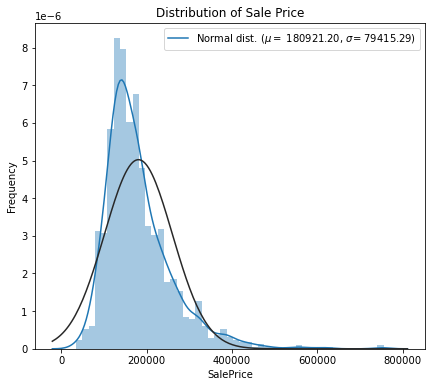

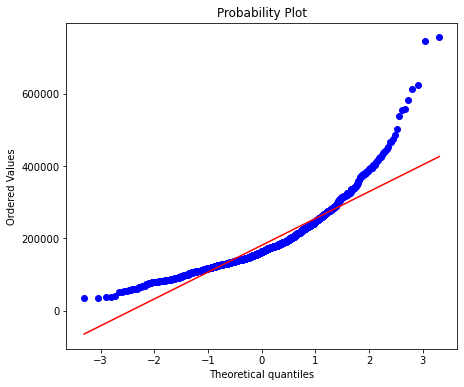

In [7]:
# Normalizing the distribution of target variable and comparing it with the original distribution
plt.figure(figsize=(7,6))
sns.distplot(df['SalePrice'],fit=norm);

# Calculating mean and std. deviation for its distribution
(mu,sigma)=norm.fit(df['SalePrice'])
print('mu={:.2f}, sigma={:.2f}'.format(mu,sigma))

#Plotting with normalized distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f}, $\sigma$= {:.2f})'.format(mu,sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('Distribution of Sale Price')

# Plotting QQ plot
fig=plt.figure(figsize=(7,6))
res=stats.probplot(df['SalePrice'],plot=plt)
plt.show()

The target variable is right skewed. In order to be able to use the linear method effectively, it needs to be transformed so as to have a normal distribution. The Q-Q plot (Quantile-Quantile Plot) will also be nearly straight.

mu=12.02,sigma=0.40


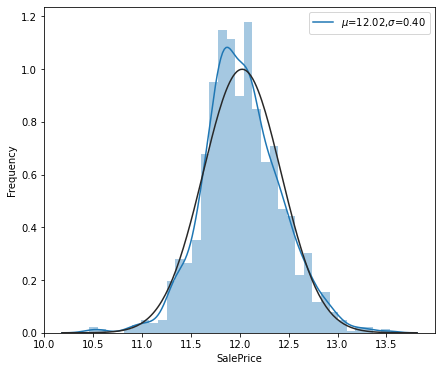

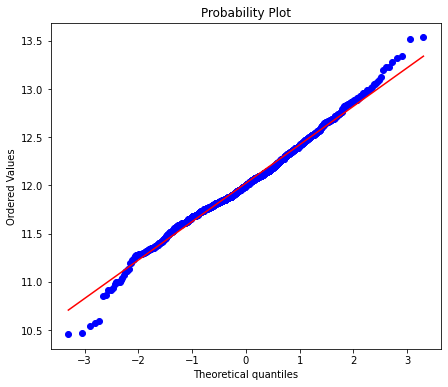

In [8]:
plt.figure(figsize=(7,6))
sns.distplot(np.log1p(df['SalePrice']),fit=norm)

(mu,sigma)=norm.fit(np.log1p(df['SalePrice']))
print('mu={:.2f},sigma={:.2f}'.format(mu,sigma))

plt.legend(['$\mu$={:.2f},$\sigma$={:.2f}'.format(mu,sigma)],loc='best')
plt.ylabel('Frequency')

# Plotting QQ-plot

fig=plt.figure(figsize=(7,6))
res=stats.probplot(np.log1p(df['SalePrice']),plot=plt)
plt.show()

### Finding Correlation Between Numeric Features

In [9]:
# Finding features with numeric data types

a=df.dtypes[df.dtypes.values=='int64']
b=df.dtypes[df.dtypes.values=='float64']
pd.concat([a,b])
#index[df.dtypes.values=='int64'  df.dtypes.values=='float64']

MSSubClass         int64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
LotFrontage      float64
MasVnrArea       float64
GarageYrBlt      float64
dtype: object

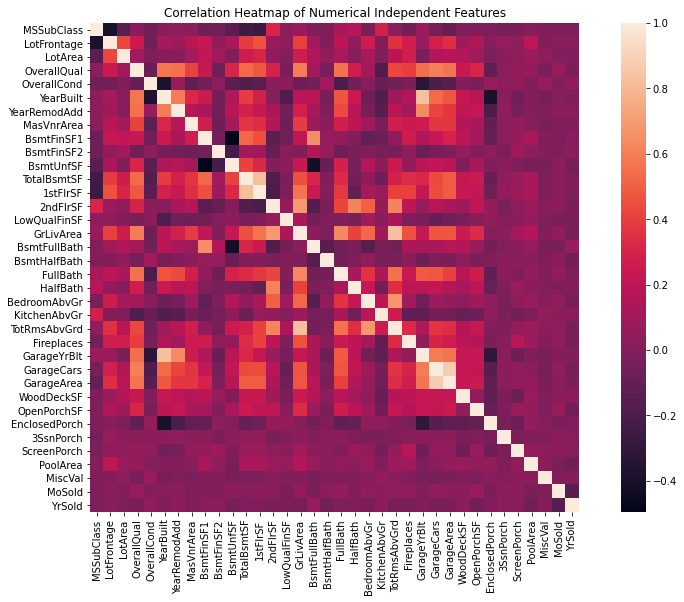

In [10]:
pd.set_option('precision',2)
plt.figure(figsize=(15,9))
sns.heatmap(df.drop(['SalePrice'],axis=1).corr(),square=True)
plt.title('Correlation Heatmap of Numerical Independent Features')
plt.show()

There are a lot of variables that are highly correlated with each other. They will be taken care of in the ElasticNetCV that reduces redundancy.

### Correlation of SalePrice and other numeric features

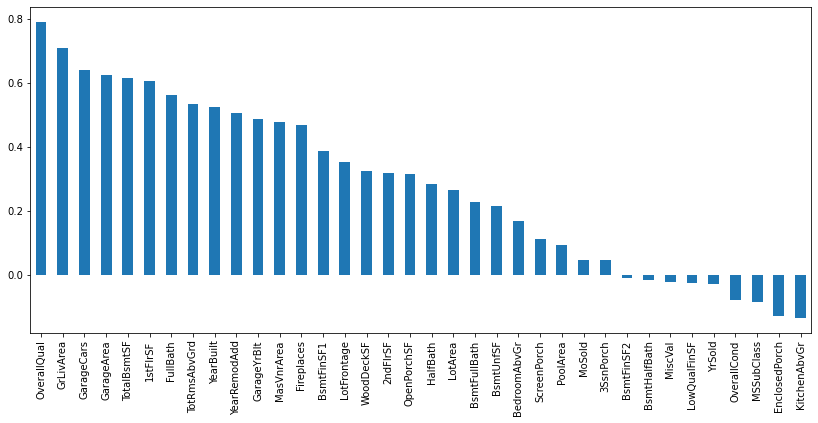

In [11]:
corr_with_sale_price = df.corr()["SalePrice"].sort_values(ascending=False)
plt.figure(figsize=(14,6))
corr_with_sale_price.drop("SalePrice").plot.bar()
plt.show()

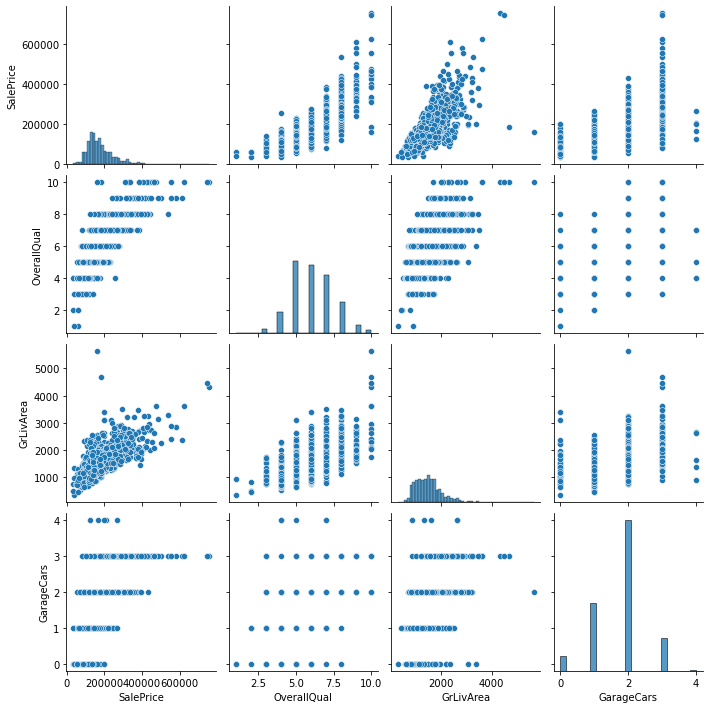

In [12]:
# Plotting pairplots of SalePrice with features having highest correlation with it

sns.pairplot(df[['SalePrice','OverallQual','GrLivArea','GarageCars']])
plt.show()

### Featuring Engineering

This process will involve:
1. Taking log transform of target varible as it is right skewed.
2. Transforming features that have a skew of more than 0.75, because skewness is a measure of the symmetry in a distribution. A symmetrical data set will have a skewness equal to 0. So, a normal distribution will have a skewness of 0. Skewness essentially measures the relative size of the two tails.So the objective of choosing features with skewed_feats>0.75 is because we are searching to work with features that have a more normal-like distribution so we apply a log transformation to normalize the distribution.
3. Introducing dummy varibales to encode categorical features.
4. Replacing missing values in columns with column means. This is the best approach when dealing with missing values in a normal distribution. Since the features will be transformed to a normal distribution, it is okay to do so. In cases where it is not possible to get a normal distribution, filling NaNs with median would be a better approach.

In [13]:
# 1
df['SalePrice']=np.log1p(df['SalePrice'])

# 2 
numeric_features=df.dtypes[df.dtypes!='object'].index
skewed_features=df[numeric_features].apply(lambda x: skew(x.dropna()))
skewed_features=skewed_features[skewed_features>0.75] # only checking for p=+ve value as it is right skewed
skewed_features=skewed_features.index # skewed_features is a series and names of the features are the indexes here
df[skewed_features]=np.log1p(df[skewed_features])

#3
df=pd.get_dummies(df)

#4
df=df.fillna(df.mean())


In [14]:
# Creating training and test sets

X,y=df.drop(['SalePrice'],axis=1),df['SalePrice']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

### ElasticNet

    -Ridge and Lasso regression are regularized linear regression models.
    
    -ElasticNet is essentially a Lasso/Ridge hybrid, that entails the minimization of an objective function that includes 
    both L1 (Lasso) and L2 (Ridge) norms.
    
    -ElasticNet is useful when there are multiple features which are correlated with one another.
    
    -The class ElasticNetCV can be used to set the parameters alpha (α) and l1_ratio (ρ) by cross-validation.
    
    -ElasticNetCV: ElasticNet model with best model selection by cross-validation.

In [15]:
cv_model=ElasticNetCV(l1_ratio=[0.1,0.5,0.7,0.9,0.95,0.99,1],eps=1e-3,n_alphas=100,fit_intercept=True,normalize=True,
                     precompute='auto',max_iter=2000,tol=0.0001,cv=6,copy_X=True,verbose=0,n_jobs=-1,positive=False,
                      random_state=0)
cv_model.fit(X_train,y_train)

print('Optimal value of alpha: {:.8f}'.format(cv_model.alpha_))
print('Optimal value of l1 ratio: {:.3f}'.format(cv_model.l1_ratio_))
print('Optimal number of iterations: {}'.format(cv_model.n_iter_))

Optimal value of alpha: 0.00013634
Optimal value of l1 ratio: 0.700
Optimal number of iterations: 84


The value of optimal alpha is between 0 and 1, indicating that it is a combination of both Lasso(l1) and Ridge(l2)

### Model Evaluation

In [16]:
y_train_pred=cv_model.predict(X_train)
y_test_pred=cv_model.predict(X_test)

# Finding R2 scores for train and test sets for the optimal model
print('Training set R2 score: {}'.format(r2_score(y_train_pred,y_train)))
print('Test set R2 score: {}'.format(r2_score(y_test,y_test_pred)))

# Find RMSE

train_mse=mean_squared_error(y_train,y_train_pred)
test_mse=mean_squared_error(y_test,y_test_pred)
train_rmse=np.sqrt(train_mse)
test_rmse=np.sqrt(test_mse)

print('Train error: {:.4f}'.format(train_rmse))
print('Test error: {:.4f}'.format(test_rmse))

Training set R2 score: 0.9352316018794964
Test set R2 score: 0.8300355301028957
Train error: 0.0963
Test error: 0.1604


A point to keep in mind is that the error value obtained above is the Root Mean Squared Logarithmic Error (RMSLE).

RMSLE measures the ratio between actual and predicted values
log((pi+1)/(ai+1)) or log(pi+1)−log(ai+1)

It can be used when you don’t want to penalize huge differences when both the values are huge numbers. Also, this can be used when you want to penalize under estimates more than over estimates.

Case a) : Pi = 600, Ai = 1000
RMSE = 400, RMSLE = 0.5108

Case b) : Pi = 1400, Ai = 1000
RMSE = 400, RMSLE = 0.3365

As it is evident, the differences are same between actual and predicted in both the cases. RMSE treated them equally however RMSLE penalized the under estimate more than over estimate.

### Feature Importance

In [17]:
feature_importance=pd.Series(data=np.abs(cv_model.coef_),index=X_train.columns)


113 features selected with a reduction of 58.91%


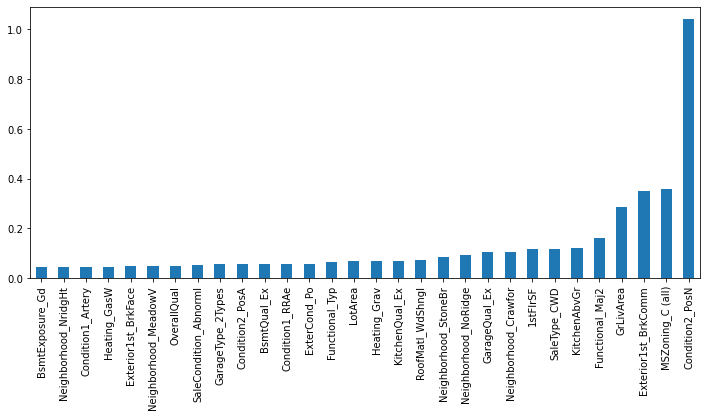

In [18]:
n_selected_features=(feature_importance>0).sum()
print('{} features selected with a reduction of {:.2f}%'.format(n_selected_features,
                                                                (1-n_selected_features/len(feature_importance))*100))
feature_importance.sort_values().tail(30).plot(kind='bar',figsize=(12,5))
plt.show()

Now we will see how the top features selected here compare with those selected by Xgboost

### XGBoost

#### 1st Run- Running with default parameters

In [19]:
xgb_model_1=XGBRegressor()
xgb_model_1.fit(X_train,y_train,verbose=False)
y_train_pred_1=xgb_model_1.predict(X_train)
y_test_pred_1=xgb_model_1.predict(X_test)

In [26]:
print('Train R2 score:',r2_score(y_train,y_train_pred_1))
print('Test R2 score:',r2_score(y_test,y_test_pred_1))

train_mse_1=mean_squared_error(y_train_pred_1,y_train)
test_mse_1=mean_squared_error(y_test,y_test_pred_1)
train_rmse_1=np.sqrt(train_mse_1)
test_rmse_1=np.sqrt(test_mse_1)

print('Train RMSLE:{:.4f}'.format(train_rmse_1))
print('Test RMSLE:{:.4f}'.format(test_rmse_1))

Train R2 score: 0.9930172284995369
Test R2 score: 0.879442965695563
Train RMSLE:0.0336
Test RMSLE:0.1351


The test RMSE here is  better than that obtained for Elastic Net

#### 2nd Run- Adding some features to improve accuracy

In [27]:
xgb_model_2=XGBRegressor(n_estimators=1000)
xgb_model_2.fit(X_train,y_train,early_stopping_rounds=5,eval_set=[(X_test,y_test)],verbose=False)

y_train_pred_2=xgb_model_2.predict(X_train)
y_test_pred_2=xgb_model_2.predict(X_test)

print('Training set R2 Score:',r2_score(y_train,y_train_pred_2))
print('Test set R2 Score:',r2_score(y_test,y_test_pred_2))

train_mse_2=mean_squared_error(y_train,y_train_pred_2)
test_mse_2=mean_squared_error(y_test,y_test_pred_2)

train_rmse_2=np.sqrt(train_mse_2)
test_rmse_2=np.sqrt(test_mse_2)

print('Train RMSLE: {:.4f}'.format(train_rmse_2))
print('Test RMSLE: {:.4f}'.format(test_rmse_2))

Training set R2 Score: 0.9930172284995369
Test set R2 Score: 0.8793660770870737
Train RMSLE: 0.0336
Test RMSLE: 0.1351


The performance of the model remained unchanged. 

#### Run 3 - Adding a learning rate

In [31]:
xgb_model_3=XGBRegressor(n_estimators=1000,learning_rate=0.05)
xgb_model_3.fit(X_train,y_train,early_stopping_rounds=5,eval_set=[(X_test,y_test)],verbose=False)

y_train_pred_3=xgb_model_3.predict(X_train)
y_test_pred_3=xgb_model_3.predict(X_test)

print('Training set R2 Score:',r2_score(y_train,y_train_pred_3))
print('Test set R2 Score:',r2_score(y_test,y_test_pred_3))

train_mse_3=mean_squared_error(y_train,y_train_pred_3)
test_mse_3=mean_squared_error(y_test,y_test_pred_3)

train_rmse_3=np.sqrt(train_mse_3)
test_rmse_3=np.sqrt(test_mse_3)

print('Train RMSLE: {:.4f}'.format(train_rmse_3))
print('Test RMSLE: {:.4f}'.format(test_rmse_3))

Training set R2 Score: 0.9913698446283224
Test set R2 Score: 0.892895748654273
Train RMSLE: 0.0367
Test RMSLE: 0.1273


Adding a learning rate led to further improvement on the test score and error rate.

In [29]:
from collections import OrderedDict

In [40]:
OrderedDict(sorted(xgb_model_3.get_booster().get_fscore().items(),key=lambda t:t[1],reverse=True))

OrderedDict([('LotArea', 462),
             ('LotFrontage', 429),
             ('GrLivArea', 296),
             ('MSSubClass', 293),
             ('BsmtUnfSF', 272),
             ('TotalBsmtSF', 254),
             ('OverallQual', 231),
             ('YearBuilt', 210),
             ('GarageArea', 201),
             ('OverallCond', 195),
             ('BsmtFinSF1', 188),
             ('MoSold', 179),
             ('1stFlrSF', 168),
             ('OpenPorchSF', 147),
             ('MasVnrArea', 139),
             ('YearRemodAdd', 130),
             ('2ndFlrSF', 126),
             ('GarageYrBlt', 108),
             ('WoodDeckSF', 106),
             ('YrSold', 82),
             ('EnclosedPorch', 81),
             ('ScreenPorch', 55),
             ('BedroomAbvGr', 54),
             ('Fireplaces', 49),
             ('SaleCondition_Abnorml', 45),
             ('BsmtFinSF2', 45),
             ('Condition1_Norm', 43),
             ('Functional_Typ', 39),
             ('MSZoning_C (all)', 36),
  

The top 4 most important features selected by XGBoost are LotArea,LotFrontage,GrLivArea and MSSubClass. Only GrLivArea has been picked by both Elastic Net and XGBoost.

Selecting relevant features and fitting the model again

In [43]:
most_relevant_features=list(dict((k,v) for k,v in xgb_model_3.get_booster().get_fscore().items() if v>=4).keys())
train_X=df[most_relevant_features]
train_y=df['SalePrice']
X_train, X_test, y_train, y_test  = train_test_split(train_X, train_y, test_size = 0.2, random_state = 0)

xgb_model_4=XGBRegressor(n_estimators=1000,learning_rate=0.05)
xgb_model_4.fit(X_train,y_train,early_stopping_rounds=5,eval_set=[(X_test,y_test)],verbose=False)

y_train_pred_4=xgb_model_4.predict(X_train)
y_test_pred_4=xgb_model_4.predict(X_test)

print('Training set R2 Score:',r2_score(y_train,y_train_pred_4))
print('Test set R2 Score:',r2_score(y_test,y_test_pred_4))

train_mse_4=mean_squared_error(y_train,y_train_pred_4)
test_mse_4=mean_squared_error(y_test,y_test_pred_4)

train_rmse_4=np.sqrt(train_mse_4)
test_rmse_4=np.sqrt(test_mse_4)

print('Train RMSLE: {:.4f}'.format(train_rmse_4))
print('Test RMSLE: {:.4f}'.format(test_rmse_4))

Training set R2 Score: 0.9890305597286111
Test set R2 Score: 0.9021689500799197
Train RMSLE: 0.0421
Test RMSLE: 0.1217


The test score and test RMSLE improved further.